In [2]:
import json
api_token = {"username":"iobananaoi","key":"0cbdda23beeb18cbb57e9e88bf26bfd1"}

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 /root/.kaggle/kaggle.json

In [3]:
import cv2
import os
import matplotlib.pyplot as plt
import zipfile
import torch
from torch import nn
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader
import kaggle

In [4]:
!kaggle datasets download -d romanleo2003/labtinkoff

labtinkoff.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
with zipfile.ZipFile("/content/labtinkoff.zip", 'r') as zip_ref:
    zip_ref.extractall()

# Data processing

In [6]:
class CCPD(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None):
        self.img_pathes = [f for f in os.listdir(img_dir) if os.path.isfile(os.path.join(img_dir, f))]
        self.img_labels = [label.split("-")[1][:-4] for label in self.img_pathes]
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        
        self.unique_symbols = set()
        labels = [(label[:3], label[3:]) for label in self.img_labels]
        for l in labels:
            self.unique_symbols.add(l[0])
            for s in l[1]: self.unique_symbols.add(s)
        

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_pathes[idx])
        image = cv2.imread(img_path)
        image = cv2.resize(image, (100, 40))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        label = self.img_labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [7]:
train = CCPD("/content/CCPD2019-dl1/train", transform=ToTensor())
#test = CCPD("/content/CCPD2019-dl1/test")

In [8]:
train_dataloader = DataLoader(train, batch_size=32)
#test_dataloader = DataLoader(test, batch_size=32, shuffle=True)

Features shape: torch.Size([32, 1, 40, 100])
τÜûA03F85


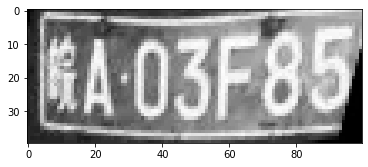

In [9]:
train_features, train_labels = next(iter(train_dataloader))
img = train_features[0].squeeze()
label = train_labels[0]
print(f"Features shape: {train_features.shape}")
print(label)
plt.imshow(img, cmap="gray")
plt.show()

# Model structure

In [10]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()

        self.layer1 = nn.Sequential(nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=1)) 
        self.layer2 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=1))
        self.layer3 = nn.Sequential(nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=1))
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(128*3589, latent_dims)
        

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.flatten(x)
        x = self.linear(x)
        return x

In [11]:
class Decoder(nn.Module):
    def __init__(self, latent_dims, n_vocab, num_layers=1, dropout=0.2):
        super(Decoder, self).__init__()

        self.lstm = nn.LSTM(latent_dims, latent_dims, num_layers, dropout=dropout, bidirectional=True)
        self.fc = nn.Linear(latent_dims*2, n_vocab)

    def forward(self, x):
        out, state = self.lstm(x)
        logits = self.fc(out)
        return logits

In [12]:
class Img2Seq(nn.Module):
    def __init__(self, latent_dims, n_vocab):
        super(Img2Seq, self).__init__()

        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims, n_vocab, 2)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Training part

In [ ]:
def train(model, dataloader):
    for i, (img, label)

In [15]:
model = Img2Seq(1000, len(train.unique_symbols))
for i, (img, label) in enumerate(train_dataloader):
    out = model(img)
    break

In [16]:
out[0]

tensor([ 0.0137, -0.0100,  0.0071,  0.0067,  0.0221,  0.0107,  0.0150,  0.0054,
         0.0150, -0.0156, -0.0101, -0.0051,  0.0146, -0.0150, -0.0050,  0.0044,
         0.0004,  0.0067,  0.0080, -0.0175,  0.0042, -0.0014, -0.0096,  0.0189,
        -0.0076,  0.0205, -0.0018, -0.0045, -0.0141,  0.0183, -0.0017, -0.0150,
        -0.0072,  0.0029, -0.0099, -0.0127, -0.0120,  0.0228,  0.0125, -0.0040,
         0.0052, -0.0177, -0.0218,  0.0226,  0.0208,  0.0192, -0.0039, -0.0055,
         0.0038, -0.0007,  0.0204, -0.0042,  0.0157, -0.0008, -0.0022,  0.0094,
        -0.0046, -0.0229, -0.0031,  0.0082, -0.0177, -0.0121,  0.0094,  0.0283,
        -0.0084,  0.0233], grad_fn=<SelectBackward0>)